In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()
%matplotlib inline
import os
import gmaps
from ipywidgets.embed import embed_minimal_html

gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Introduction 
Depending on the business, often sales data is recorded in a nonstandard form. But in order to run analytics on sales data, raw data files need to be cleaned up and merged together in a meaningful way. Therefore, this Jupyter notebook merges two CSV files (one addressing delivery times associated with geoinformation, the other individual sales). The notebook unpacked many fields from geoinformation such as zip code and city and average income. It also assessed metrics by graphing extrapolated data. The data revealed that most of the sales are concentrated in large cities: San Francisco, Oakland, San Diego. The findings reveal that bay area business strategies are effective relative to the rest of the state. The heatmap graph of sales reveals many potential markets for growth. 

# 1. Join these tables in a meaningful way 
Below I'll join the tables with merge on the column 'order id'. It should be noted that the tables are not of equal size, thus some of the features (columns) will have missing values. 

In [127]:
df_delivery = pd.read_csv('../data/delivery_geography.csv')
df_delivery.head()

,orderid,latitude,longitude,estimateddeliverytime
0,1552679,37.697073,-122.485903,259.0
1,1552697,37.782185,-122.454544,54.0
2,1552675,37.780840,-122.395820,228.0
3,1552934,37.783131,-122.388962,209.0
4,1552983,37.323786,-121.878904,345.0


In [128]:
df_prices = pd.read_csv('../data/delivery_prices.csv')
df_prices.head()

,orderid,deliveredat,totalprice
0,1552553,2017-08-08T00:02:29.980+00:00,176.11
1,1552559,2017-08-08T00:09:06.077+00:00,71.03
2,1552499,2017-08-08T00:15:03.847+00:00,61.95
3,1552617,2017-08-08T00:16:40.820+00:00,62.40
4,1552632,2017-08-08T00:31:27.957+00:00,64.16


In [129]:
# Change the index to 'orderid' column
df_prices = df_prices.set_index('orderid')
df_delivery = df_delivery.set_index('orderid')
# Merge on 'oderid' column
df_join = pd.merge(df_prices, df_delivery, how='outer',
                   left_index=True, right_index=True)
# rename columns
df_join.columns = ['date', 'sales', 'lat', 'lon', 'delivery time']
# sample of table values
df_join[1020:1025]

,date,sales,lat,lon,delivery time
orderid,,,,,
1553535,NaN,NaN,34.012453,-118.457838,1077.0
1553536,2017-08-08T02:26:01.213+00:00,43.73,37.779351,-122.497121,235.0
1553537,2017-08-08T02:30:57.383+00:00,137.47,37.807403,-122.301621,172.0
1553538,2017-08-08T02:38:09.680+00:00,56.94,37.748804,-122.423628,20.0
1553539,2017-08-08T03:30:50.513+00:00,65.22,37.485039,-122.192457,119.0


In [131]:
'Number of rows for df_join dataframe:  {}'.format(len(df_join))

'Number of rows for df_join dataframe:  3849'

# 2. Find at least one source of external information that you think would augment this table well and add it into the joined table.

- Using the uszipcode 0.1.3 python package I can look up the zipcode, city, and average income for each latitude, longitude entry
- Using the Date Functionality in Pandas will allow the unpacking of the time stamp into days and time, which will give a more granular view of when purchases occur. 

Even though the sample data did not vary in weekdays this information would be a good metric to know for market exploration purposes.


In [6]:
def geo_data(df, lat, lon):
    '''This function returns the dataframe with zipcode, average income, and city as columns. 
    The function takes a dataframe and column names as strings for latitude and longitude data.
    It uses the uszipcode library to convert latitude, longitude into zipcode, city, and avg income
    for geo data.'''
    # average income
    df['avg income'] = df.apply(lambda x: search.by_coordinate(x[lat], x[lon], radius=4, returns=1)[
        0]['Wealthy'] if (x[lat] > 0) else None, axis=1).round(0)
    # zipcode
    df['zipcode'] = df.apply(lambda x:  search.by_coordinate(
        x[lat], x[lon], radius=4, returns=1)[0]['Zipcode'] if (x[lat] > 0) else None, axis=1)
    # city
    df['city'] = df.apply(lambda x:  search.by_coordinate(
        x[lat], x[lon], radius=4, returns=1)[0]['City'] if (x[lat] > 0) else None, axis=1)

In [7]:
geo_data(df_join, 'lat', 'lon')
df_join[1020:1025]  #sample of table values 

,date,sales,lat,lon,delivery time,avg income,zipcode,city
orderid,,,,,,,,
1553535,NaN,NaN,34.012453,-118.457838,1077.0,39765.0,90405,Santa Monica
1553536,2017-08-08T02:26:01.213+00:00,43.73,37.779351,-122.497121,235.0,29058.0,94121,San Francisco
1553537,2017-08-08T02:30:57.383+00:00,137.47,37.807403,-122.301621,172.0,14127.0,94607,Oakland
1553538,2017-08-08T02:38:09.680+00:00,56.94,37.748804,-122.423628,20.0,27502.0,94110,San Francisco
1553539,2017-08-08T03:30:50.513+00:00,65.22,37.485039,-122.192457,119.0,14781.0,94063,Redwood City


In [8]:
def df_day(df, timestamp):
    '''This functions converts a string timestamp into pandas datetime structure. 
    The function makes a new column by extacting the weekday.'''
    # Convert string timestamp to pandas datetime
    df[timestamp] = pd.to_datetime(df_join[timestamp])
    # Make new column with weekday
    df['day'] = df[timestamp].dt.weekday_name

In [9]:
df_day(df_join, 'date')
df_join[1020:1025]  #sample of table values 

,date,sales,lat,lon,delivery time,avg income,zipcode,city,day
orderid,,,,,,,,,
1553535,NaT,NaN,34.012453,-118.457838,1077.0,39765.0,90405,Santa Monica,NaN
1553536,2017-08-08 02:26:01.213,43.73,37.779351,-122.497121,235.0,29058.0,94121,San Francisco,Tuesday
1553537,2017-08-08 02:30:57.383,137.47,37.807403,-122.301621,172.0,14127.0,94607,Oakland,Tuesday
1553538,2017-08-08 02:38:09.680,56.94,37.748804,-122.423628,20.0,27502.0,94110,San Francisco,Tuesday
1553539,2017-08-08 03:30:50.513,65.22,37.485039,-122.192457,119.0,14781.0,94063,Redwood City,Tuesday


A list of the features for the table above : <br>
- **orderid**: unique identifier per order (int)
- **date**: Timestamp of delivery 
- **sales**: Total product sold (USD)
- **lat**: Latitude: delivery location (degrees)
- **lon**: Longitude: delivery location (degrees)
- **delivery time**: An estimate of how long a delivery took (seconds)
- **avg income**: Average income for given zipcode  
- **zipcode**: The zipcode corresponding to delivery location  
- **city**: The city corresponding to geoinformation 
- **day**: The day of the week for delivery

In [10]:
# Count the instances for each weekday
df_join.day.value_counts()

Tuesday    3352
Name: day, dtype: int64

# 3. Explain (at a high level) how you would perform this join on a live data pipeline in a performant way.

To perform this join on a pipeline I would implement the join SQL command, e.g, FULL OUTER JOIN. Or design the data capture to record to a single table instead of two. 


# 4. Use any clustering/classification technique to divide the data into at least 3 and at most 20 groups. Annotate your joined table with this classification.

A list of the features for the clustered table below : <br>
- **city**: The city corresponding to geoinformation 
- **zipcode**: The zipcode corresponding to delivery location  
- **sales**: Average sale for zipcode  (USD)
- **delivery time**: Average delivery time for zipcode  
- **avg income**: Average income for zipcode

In [23]:
# Average sale and income per zipcode, only showing the first 20 rows 
(df_join.groupby(['city', 'zipcode'])
 .aggregate('mean')
 .drop(df_join[['lat', 'lon']], axis=1)
 .round(1))[0:20]

sales  delivery time  avg income
city       zipcode                                  
Alameda    94501     70.4          296.7     24503.0
           94502     82.5          127.0     37282.0
Albany     94706     75.7          305.8     24630.0
Anaheim    92801     84.8           23.0     12744.0
Aptos      95003    126.7          344.0     24796.0
Atherton   94027     78.3          226.6    130531.0
Belmont    94002     56.5          181.4     41416.0
Berkeley   94702     71.5          235.2     21607.0
           94703     67.2          182.0     19617.0
           94704     63.6          218.0      6931.0
           94705     43.8          188.1     42749.0
           94707    102.5          137.0     40213.0
           94709     67.1          242.2     18362.0
           94710     69.7          148.6     18683.0
Brisbane   94005     62.5          175.1     46645.0
Burlingame 94010     52.2          214.9         NaN
Campbell   95008     62.7            0.0     30810.0
Capitola   95010     92.8          321.6     22951.0
Carson     90745     36.0          145.0     16970.0
           90746     54.2          675.5     19531.0

In [16]:
# The following dataframe groups df_join by city
df_city_group = (df_join.set_index('city').groupby(level=0)['sales']
                 .agg({'avg sale': np.mean, 'sum': np.sum})
                 .astype(int))

In [25]:
# Sort by sum of purchases for each city in descending order, displaying first 5 entries 
df_city_group.sort_values(by='sum', ascending=False).head()

,avg sale,sum
city,,
San Francisco,71,72295
Oakland,63,21071
San Diego,70,16746
San Mateo,69,10443
Santa Cruz,85,8987


In [24]:
# Sort by avg purchase for each city in descending order, displaying first 5 entries 
df_city_group.sort_values(by='avg sale', ascending=False).head()

,avg sale,sum
city,,
Laguna Hills,126,252
Aptos,126,3548
Santa Ana,113,226
Costa Mesa,113,1021
San Ysidro,106,106


In [42]:
# The following dataframe groups df_join by city and yields average wait time, displaying first 5 entries 
df_city_group_time = (df_join.set_index('city').groupby(level=0)['delivery time']
                 .agg({'avg time': np.mean, 'max': np.max})
                 .astype(int))
df_city_group_time.sort_values(by='avg time', ascending=False).head()

,avg time,max
city,,
Los Gatos,803,1604
Carson,498,2264
Hermosa Beach,452,2327
National City,428,1288
Redondo Beach,403,1766


# 5. Create any visualization of the data that you think would display meaningful insight.

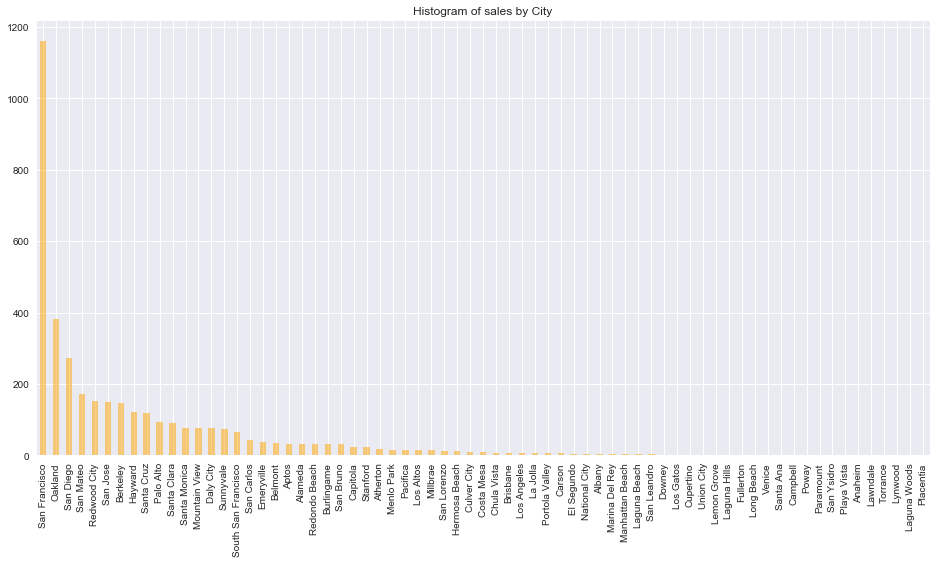

In [28]:
df_join.city.value_counts().plot(kind='bar', alpha=.5, color='orange',  figsize=(16, 8), title ='Histogram of sales by City'); 

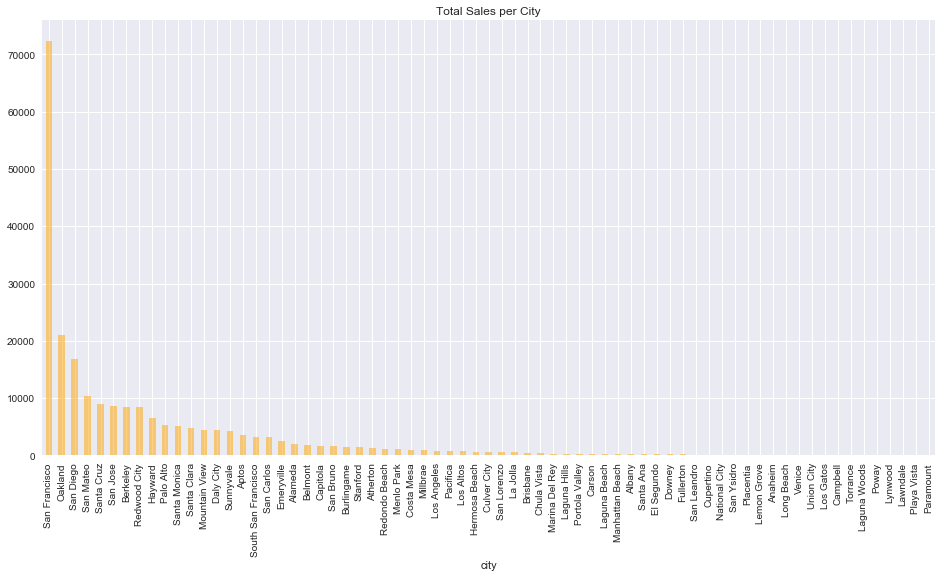

In [43]:
df_city_group['sum'].sort_values(ascending = False).plot(kind='bar', alpha=.5, color='orange',  figsize=(16, 8), title ='Total Sales per City'); 

In [126]:
# What percentage of total sales do San Francisco and Oakland contribute?
def perc_sales(df, cities, sum_):
    '''A function to calculate total percentage of sales from a list of cities. 
    The inputs are a dataframe, list of cities, and a string column name for sum of sales'''
    return 'The total sales contributed for listed cities: {:0.1f}%'.format(sum([df.loc[item, sum_] for item in cities]) / df[sum_].sum() * 100)


perc_sales(df_city_group, ['San Francisco', 'Oakland'], 'sum')

'The total sales contributed for listed cities: 41.1%'

'Average sale $69 with a median of $55'

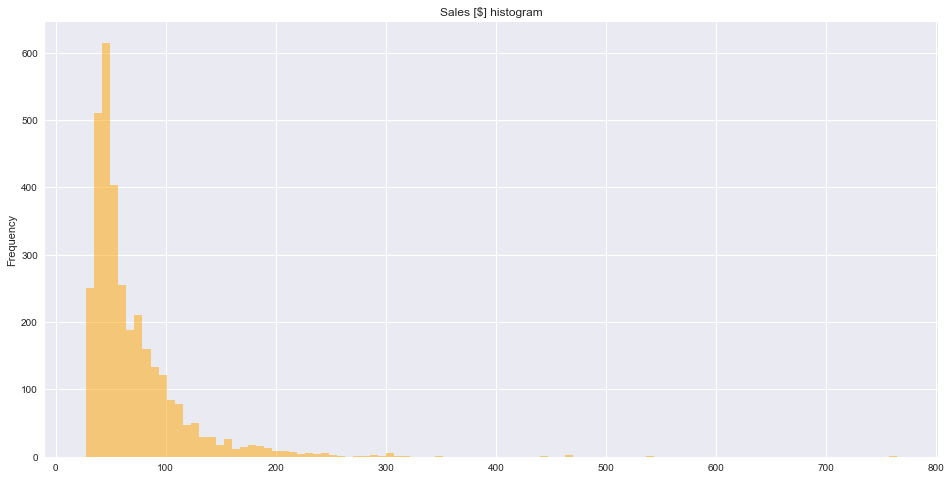

In [75]:
df_join.sales.plot.hist(
    alpha=.5, color='orange', bins=100,  figsize=(16, 8), title='Sales [$] histogram')

'Average sale ${} with a median of ${}'.format(
    "%.0f" % df_join.sales.mean(), "%.0f" % df_join.sales.median())

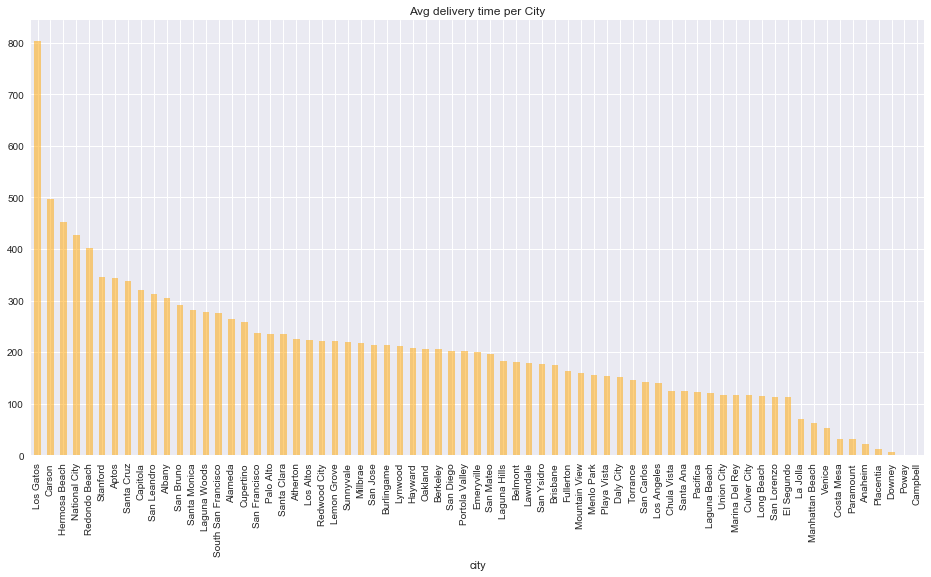

In [45]:
(df_city_group_time['avg time'].sort_values(ascending = False)
    .plot(kind='bar', alpha=.5, color='orange',  figsize=(16, 8), title ='Avg delivery time per City')); 

'Average estimated delivery time: 227 s with a median of 150 s'

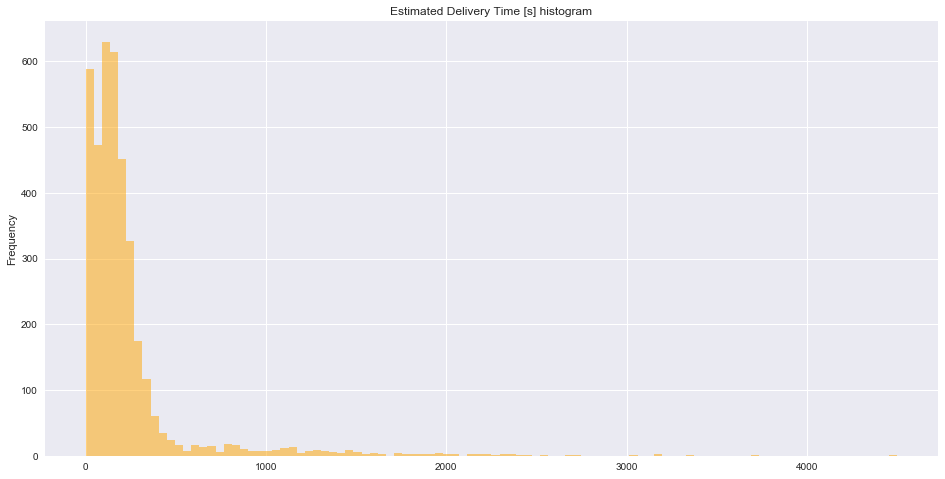

In [40]:
df_join['delivery time'].plot.hist(
    alpha=.5, color='orange', bins=100,  figsize=(16, 8), title='Estimated Delivery Time [s] histogram')

'Average estimated delivery time: {} s with a median of {} s'.format(
    "%.0f" % df_join['delivery time'].mean(), "%.0f" % df_join['delivery time'].median())

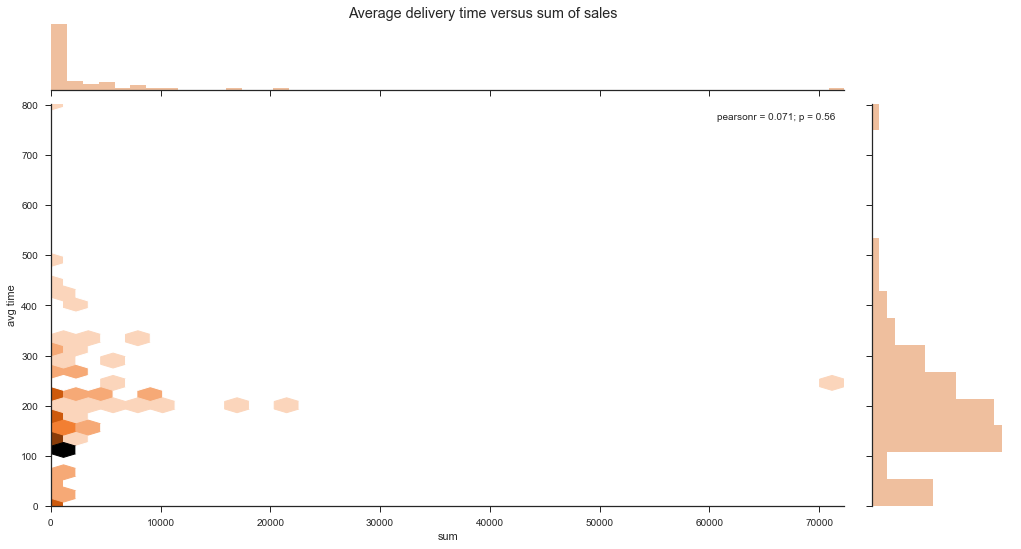

In [180]:
# plots average time versus sum of sales for city 
# merges dataframes which have total sales and average delivery, merges on cities 
df_time_sales = pd.merge(df_city_group, df_city_group_time, how='outer',
                   left_index=True, right_index=True)

sns.set(style="ticks");
x = df_time_sales['sum']
y = df_time_sales['avg time']
g = sns.jointplot(x, y, kind="hex",  color="#d95f0e")
g.fig.set_size_inches(16,8)
g.fig.suptitle('Average delivery time versus sum of sales');

In [130]:
# The following code generates a heatmap with location data
# load a Numpy array of (latitude, longitude) pairs from dataframe
locations = df_join[["lat", "lon"]].dropna()
# Center map on bakersfield
bakersfield_coord = (35.376175, -119.022102)
fig = gmaps.figure(center=bakersfield_coord, zoom_level=6)
# Generate heatmap for locations
fig.add_layer(gmaps.heatmap_layer(locations))
# Used to export map as html
embed_minimal_html('map.html', views=[fig])

# 6. Explain (at a high level) how you could use any insights derived above to advance the company financially.

Starting with the first graph above, the **Histogram of Sales by City** we see that San Francisco yields the most sales. The sales in San Francisco are nearly 3 times the sales of Oakland—the second leader in sales transactions. One could conclude that whatever marketing strategies are being used in used in San Francisco should be executed in other cities as well, especially cities in the east bay. However, local competition could be capturing the Oakland market.

The next graphic **Total Sales per City** essentially mirrors the previous. Ostensibly the number of transactions is closely correlated with total sales generated. We see San Francisco generated more than 3 times the sales of Oakland. The two cities (San Francisco and Oakland) accounted for 41% of total sales.

The next graphic of interest is the **Estimated Delivery Time [s] histogram**. It demonstrates that on the whole delivery times are well behaved with not many outlier points that demand attention for curtailing delivery times. This is great! Whichever best practices are being used here should be applauded. From the graphic **Avg delivery time per City**, we see the city of Los Gatos had the highest average delivery time (800 s), nearly the 3.5 times the average time of 227 s. The long times could be due to the few sales in that city. Nearby San Jose had average delivery times, but much greater sales than Los Gatos. From the graph **Average delivery time versus sum of sales**  we see average delivery times do not scale down with total sales, i.e. no correlation. For delivery times there seems to be a regression to the mean of 227 s. 

Unfortunately, there was insufficient day and time data. Such data could have yielded the day and time most purchases are made. Armed with that information, one such testable hypothesis, perhaps on a smaller market, could have been to run promotions on days when sales are low. 

The heatmap below shows hot spots for where most of the sales are geographical generated. Most of the high-density locations (Bay Area, Los Angeles, San Diego) are well represented. However, medium-sized cities like Sacramento and Fresno are virtually untapped. Moreover, the San Joaquin Valley is a largely untapped market.


In [1]:
%%HTML
<iframe width = "100%" height = "475" src="map.html"></ iframe>